https://github.com/SaoYan/LearnToPayAttention
## Learn to pay attention

In [1]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torchnet as tnt
from torchnet.engine import Engine
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models


from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook as tqdm
from torchsummary import summary

print(torch.__version__)
device = torch.device('cuda:0')

1.2.0


In [2]:
class Weedread(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.input_images = np.array(hf.get('data'), np.uint8)
        self.target_labels = np.array(hf.get('labels')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return self.input_images.shape[0]

    def __getitem__(self, idx):
        images = self.input_images[idx]
        classes = self.target_labels[idx][1]
        family =  self.target_labels[idx][0]
        if self.transform is not None:
            images = self.transform(images)
        images = images
        
        return images, classes, family

In [3]:
INPUT_CHANNEL = 3
BATCH_SIZE = 64
normalize = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.Resize((96,96)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

imagenet_classes = range(1, 22)

data_path = os.path.dirname(os.getcwd()) + "/data/weed/"
Train_data = Weedread(data_path + "train.h5", transform=normalize)
Test_data = Weedread(data_path + "val.h5", transform=normalize)

Train_dataloader = DataLoader(dataset=Train_data, batch_size = BATCH_SIZE, shuffle=True)
Test_dataloader = DataLoader(dataset=Test_data, batch_size = BATCH_SIZE, shuffle=False)

print(Train_data.__len__())
def get_iterator(mode):
    if mode is True:
        return Train_dataloader
    elif mode is False:
        return Test_dataloader

125498


In [4]:
class ProjectorBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ProjectorBlock, self).__init__()
        self.op = nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=1, padding=0, bias=False)
    def forward(self, inputs):
        return self.op(inputs)

class LinearAttentionBlock(nn.Module):
    def __init__(self, in_features, normalize_attn=True):
        super(LinearAttentionBlock, self).__init__()
        self.normalize_attn = normalize_attn
        self.op = nn.Conv2d(in_channels=in_features, out_channels=1, kernel_size=1, padding=0, bias=False)
    def forward(self, l, g):
        N, C, W, H = l.size()
        #c = self.op(l+g) # batch_sizex1xWxH
        c = (l * g).sum(dim=1)
        
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        g = torch.mul(a.expand_as(l), l)
        if self.normalize_attn:
            g = g.view(N,C,-1).sum(dim=2) # batch_sizexC
        else:
            g = F.adaptive_avg_pool2d(g, (1,1)).view(N,C)
        return c.view(N,1,W,H), g

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


class ResNet_baseline(nn.Module):
    def __init__(self, input_channel=1, num_classes=21, normalize_attn=True):
        super(ResNet_baseline, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        set_parameter_requires_grad(resnet18, False)
        
        #original ResNet
        self.lower_layer = torch.nn.Sequential(*(list(resnet18.children())[:-5]))
        self.first_attention = torch.nn.Sequential(*(list(resnet18.children())[-5:-4]))
        self.second_attention = torch.nn.Sequential(*(list(resnet18.children())[-4:-3]))
        self.higher_layer = torch.nn.Sequential(*(list(resnet18.children())[-3:-1]))
        
        self.classifier = nn.Linear(in_features=512 * 2, out_features=num_classes, bias=True)
        
        #attention part
        self.projector1 = ProjectorBlock(128, 512)
        self.projector2 = ProjectorBlock(256, 512)
        self.attn1 = LinearAttentionBlock(in_features=512, normalize_attn=normalize_attn)
        self.attn2 = LinearAttentionBlock(in_features=512, normalize_attn=normalize_attn)
        
            
    def forward(self, x):
        x = self.lower_layer(x)
        local1 = self.first_attention(x)
        local2 = self.second_attention(local1)
        glob = self.higher_layer(local2)
        
        c1, g1 = self.attn1(self.projector1(local1), glob)
        c2, g2 = self.attn2(self.projector2(local2), glob)
    
        g = torch.cat((g1, g2), dim=1)
        x = self.classifier(g)
    
        return [x, c1, c2]

In [5]:
_model = ResNet_baseline()
test_images, _, _ = next(iter(Test_dataloader))

#summary(_model, input_size= test_images[0].size(), device="cpu")
_model.to(device)

ResNet_baseline(
  (lower_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [6]:
class lossCombine(nn.Module):
    def __init__(self, w=[1./21] * 21):
        super(lossCombine, self).__init__()
        weights = torch.tensor(w).to(device)
        self.class_loss = nn.CrossEntropyLoss()

    def forward(self, predicted, true):
        predicted = F.softmax(predicted, dim=1)
        return self.class_loss(predicted, true)
    
_loss = lossCombine()

In [7]:
def main():
    #main processor
    def h(sample):
        data, cls, _, training = sample
        
        if(training):
            _model.train()
        else:
            _model.eval()
        labels = torch.LongTensor(cls).to(device)
        data = data.to(device).float()
        
        f, _, _ = _model(data)
        loss = _loss(f, labels)
        
        p = F.softmax(f, dim=1)
        return loss, p
    
    #---------log--------------
    def plot_log(log):
        log = np.array(log)
        fig = plt.figure(figsize = (12, 6))
        #loss
        plt.plot(log[:,0]); plt.plot(log[:,2])
        plt.title("Loss per epoch"); plt.xlabel("epochs"); plt.ylabel("error")
        plt.legend(["training loss", "validation loss"])
        plt.show()
        fig = plt.figure(figsize = (12, 6))
        #accuracy
        max_value = np.round(np.max(log[:, 3]), decimals=4)
        max_index = np.argmax(log[:, 3])
        plt.plot(log[:,1]); plt.plot(log[:,3])
        plt.text(max_index, max_value, str(max_value), fontsize=10)
        plt.title("Accuracy per epoch"); plt.xlabel("epochs"); plt.ylabel("ACC")
        plt.legend(["training accuracy", "validation accuracy"])
        plt.show()
        
    log = []
    engine = Engine()
    EPOCHS = 300
    optimizer = torch.optim.Adadelta(_model.parameters(), lr=0.01)
    meter_loss = tnt.meter.AverageValueMeter()
    classerr = tnt.meter.ClassErrorMeter(accuracy=True)
    
    def reset_meters():
        classerr.reset()
        meter_loss.reset()

    def on_sample(state):
        state['sample'].append(state['train'])

    def on_forward(state):
        classerr.add(state['output'].data, torch.LongTensor(state['sample'][1]))
        meter_loss.add(state['loss'].item())

    def on_start_epoch(state):
        reset_meters()
        state['iterator'] = tqdm(state['iterator'], desc="[Epoch %d / %d]"%(state['epoch'] + 1, EPOCHS))

    def on_end_epoch(state):
        log.append([])
        display.clear_output(wait=True)
        print('Training loss: %.4f, accuracy: %.4f%%' % (meter_loss.value()[0], classerr.value()[-1]))
        # do validation at the end of each epoch
        log[-1].append(meter_loss.value()[0])
        log[-1].append(classerr.value()[0])
        
        reset_meters()
        engine.test(h, get_iterator(False))
        print('Testing loss: %.4f, accuracy: %.4f%%' % (meter_loss.value()[0], classerr.value()[-1]))
        log[-1].append(meter_loss.value()[0])
        log[-1].append(classerr.value()[0])
        
        if(classerr.value()[-1] == np.max(np.array(log)[:, 3])):
            torch.save(_model.state_dict(), 'epochs/ResNet18-attention2.pt')
        
        
        test_sample = next(iter(get_iterator(False)))
        ground_truth = (test_sample[0].float())
        _, c1, c2 = _model(ground_truth.to(device))
        
        visualize_attn_softmax(ground_truth, c=c2, up_factor=16, nrow = 8, name=str(state['epoch']), path = "results2-2/")
        visualize_attn_softmax(ground_truth, c=c1, up_factor=8, nrow = 8, name=str(state['epoch']), path = "results2-1/")
        plot_log(log)
        plt.pause(0.005)
        
        
        
    engine.hooks['on_sample'] = on_sample
    engine.hooks['on_forward'] = on_forward
    engine.hooks['on_start_epoch'] = on_start_epoch
    engine.hooks['on_end_epoch'] = on_end_epoch
    engine.train(h, get_iterator(True), maxepoch=EPOCHS, optimizer=optimizer)

In [8]:
import torchvision.utils as utils
import cv2

def visualize_attn_softmax(I, c, up_factor, nrow, name, path):
    # image
    img = utils.make_grid(I, nrow=nrow, normalize=True, scale_each=True)
    img = img.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
    N,C,W,H = c.size()
    a = F.softmax(c.view(N,C,-1), dim=2).view(N,C,W,H)
    if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=nrow, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # add the heatmap to the image
    vis = np.uint8(255*(0.6 * img + 0.4 * attn))
    cv2.imwrite(path + name + ".png", vis)
    return torch.from_numpy(vis).permute(2,0,1)

Training loss: 2.1350, accuracy: 98.8207%
Testing loss: 2.1740, accuracy: 94.9517%


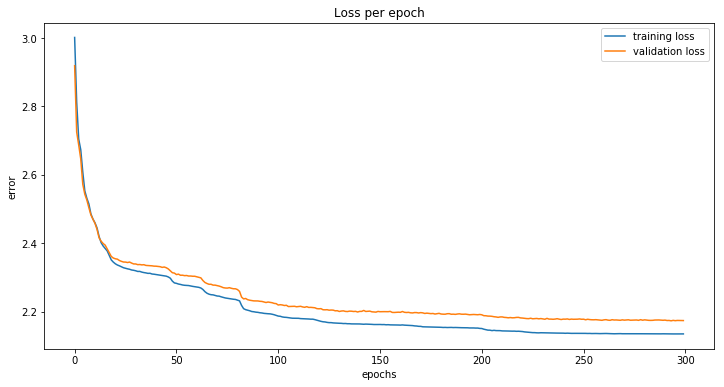

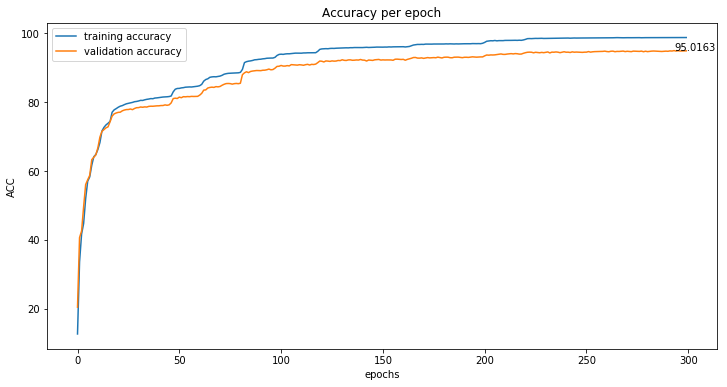

In [9]:
main()